In [1]:
import time
import data_extract as de
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import strategy as s

In [61]:
#Setting variables

start_date = '2021-01-01'



In [62]:
#Loading datasets

#load_actual_data = de.ACDB().get_ERCOT_load_actuals()[de.ACDB().get_ERCOT_load_actuals()['StartTime'] > start_date]
#load_forecast_data = de.ACDB().get_ERCOT_load_forecasts()[de.ACDB().get_ERCOT_load_forecasts()['StartTime'] > start_date]
#temp_data = de.ACDB().get_temp_forecasts()[de.ACDB().get_temp_forecasts()['StartTime'] > start_date]
#da_data = de.ACDB().get_DAM_hub_spp()[de.ACDB().get_DAM_hub_spp()['StartTime'] > start_date]
#rt_data = de.ACDB().get_RT_hub_spp()[de.ACDB().get_RT_hub_spp()['StartTime'] > start_date]
#inter_forecast_data = de.ACDB().get_intermittent_forecast()[de.ACDB().get_intermittent_forecast()['StartTime'] > start_date]
#inter_actual_data = de.ACDB().get_intermittent_actuals()[de.ACDB().get_intermittent_actuals()['StartTime'] > start_date]
#outages_data = de.ACDB().get_total_outages()[de.ACDB().get_total_outages()['StartTime'] > start_date]
#ng_data = de.ACDB().get_NGLD1_prices()[de.ACDB().get_NGLD1_prices()['TradeDate'] > start_date]
#hr_data = de.ACDB().get_North_HR()[de.ACDB().get_North_HR()['TradeDate'] > start_date]




### Analyzing the impact of trading ahead of time

#### Base case analysis to focus on trading 2 weeks out

In [63]:
#Loading pre-processed dataframes

dart_data = de.ACDB().get_dart_data()[['StartTime','north_rt','north_da','north_dart']]
ice_data = de.ACDB().get_ice_north_custom(-1) #2nd week contract

In [64]:
#Resampling dart data into daily averages

dart_data = dart_data.resample('D', on  = 'StartTime').mean().reset_index()

In [65]:
#Merging ICE and DART prices

data = ice_data.merge(dart_data, left_on = 'trade_date', right_on = 'StartTime')

In [66]:
#calculating spread between DA and price 2-weeks ago

data['spread'] = data['north_da'] - data['SettlementPrice']
data['short_dart'] = data['north_dart']*24*100
data['short_spread'] = data['spread']*16*-100

#Removing URI
uri_dates = ['2021-02-11','2021-02-12','2021-02-13','2021-02-14','2021-02-15','2021-02-16','2021-02-17','2021-02-18','2021-02-19','2021-02-26']
outliers = ['2021-02-26', '2019-08-30','2021-02-24','2021-03-01','2022-02-14'] #spread greater than 500, outliers

data = data[~data['trade_date'].isin(uri_dates)]
data = data[~data['trade_date'].isin(outliers)]



In [67]:
#Date filter

ice = data[data['trade_date']>'2023-01-01']


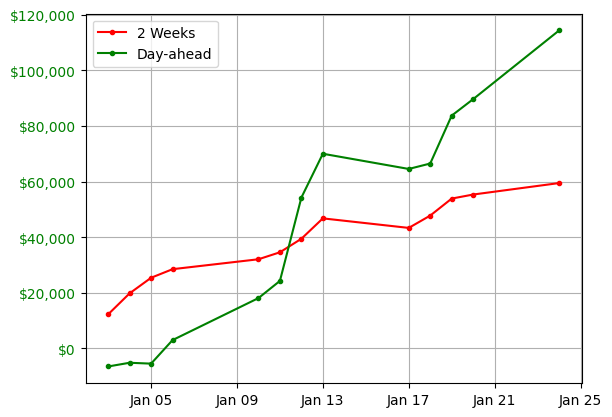

<Figure size 2000x2000 with 0 Axes>

In [68]:

fig, ax = plt.subplots()

ax.plot(ice['StartTime'],ice['short_spread'].cumsum(), label = "2 Weeks", marker = ".", color = 'red')
ax.plot(ice['StartTime'],ice['short_dart'].cumsum(), label = "Day-ahead", marker = ".", color = 'green')

ax.yaxis.set_major_formatter('${x:1,.0f}')

ax.yaxis.set_tick_params(which='major', labelcolor='green',
                         labelleft=True, labelright=False)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))



ax.grid()
ax.legend()
plt.figure(figsize=(20,20))
plt.show(block=False)


In [79]:
ice = de.ACDB().get_ICE_North_Prices()[de.ACDB().get_ICE_North_Prices()['TradeDate']>'2018-01-01'][['TradeDate','Strip','SettlementPrice','Contract']]
wknd_ice = ice

ice = ice[ice['Contract'] == 'END']
wknd_ice = wknd_ice[wknd_ice['Contract'] == 'NED']

data = pd.DataFrame()

data['trade_date'] = ice['TradeDate'].unique()
data['second_trade_date'] = data['trade_date'].apply(lambda x:x + timedelta(days = -14))

df = data.merge(ice, left_on = ['trade_date','second_trade_date'], right_on = ['Strip','TradeDate'])

wknd = pd.DataFrame()
wknd['trade_date'] = pd.date_range('2018-01-01',pd.to_datetime(datetime.today().strftime("%Y-%m-%d")) - timedelta(days=1), freq = 'd')
wknd = wknd[~wknd['trade_date'].isin(data['trade_date'])]
wknd['second_trade_date'] = wknd['trade_date'].apply(lambda x:x + timedelta(days = -4))
df_wknd = wknd.merge(wknd_ice, left_on = ['trade_date','second_trade_date'], right_on = ['Strip','TradeDate'])

df_final = pd.concat([df,df_wknd], ignore_index=True)



# Strategy buy/sell early

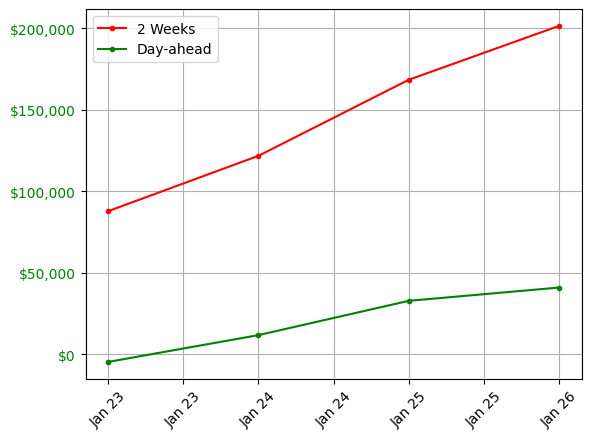

# Term Structure

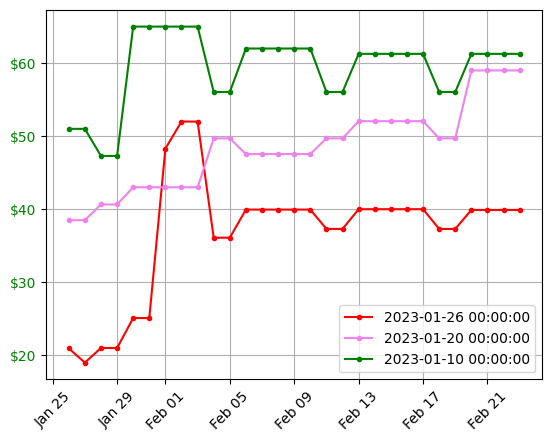

In [2]:
de.ACDB().get_term_structure(window_1 = 6, window_2 = 10, days_ahead = 28, contract_name = "END")